Read AnnData and Look for Differentially Expressed Genes

In [1]:
import scanpy as sc
import numpy as np
import random
import matplotlib.pyplot as plt
import scanpy.external as sce
import nsforest as ns
sc.settings.verbosity = 3
sc.set_figure_params(dpi=100)
np.random.seed(66)

adata = sc.read_h5ad("E:/Mouse_V1/Projection_Seq_P28_Glut_Mixed.h5ad")

In [2]:
adata.uns["log1p"]["base"] = 2

In [3]:
adata = adata[adata.obs["subclass"] == "L2/3", :]

In [4]:
adata.obs["UPBs"] = [None] * adata.shape[0]

upb_combos = ["1", "2", "4", "6", "1-2", "1-4", "1-6", "2-4", "2-6", "4-6", "1-2-4", "1-2-6", "2-4-6"]

for combo in upb_combos:
    cols = ["UPB" + dg for dg in combo.split("-")]
    mask = np.sum(adata.obs[cols] > 1, axis=1) == len(cols)
    adata.obs.loc[mask, "UPBs"] = combo

C:\Users\TLab\AppData\Local\Temp\ipykernel_5152\3785406748.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["UPBs"] = [None] * adata.shape[0]


In [5]:
adata.obs["LM"] = np.sum(adata.obs[["UPB1", "UPB4"]], axis=1) > 1
adata.obs["RL"] = np.sum(adata.obs[["UPB2", "UPB6"]], axis=1) > 1

In [6]:
adata.obs["VISs"] = [None] * adata.shape[0]

vis_combos = ["LM", "RL", "LM-RL"]

for combo in vis_combos:
    cols = combo.split("-")
    mask = np.sum(adata.obs[cols] == True, axis=1) == len(cols)
    adata.obs.loc[mask, "VISs"] = combo

C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


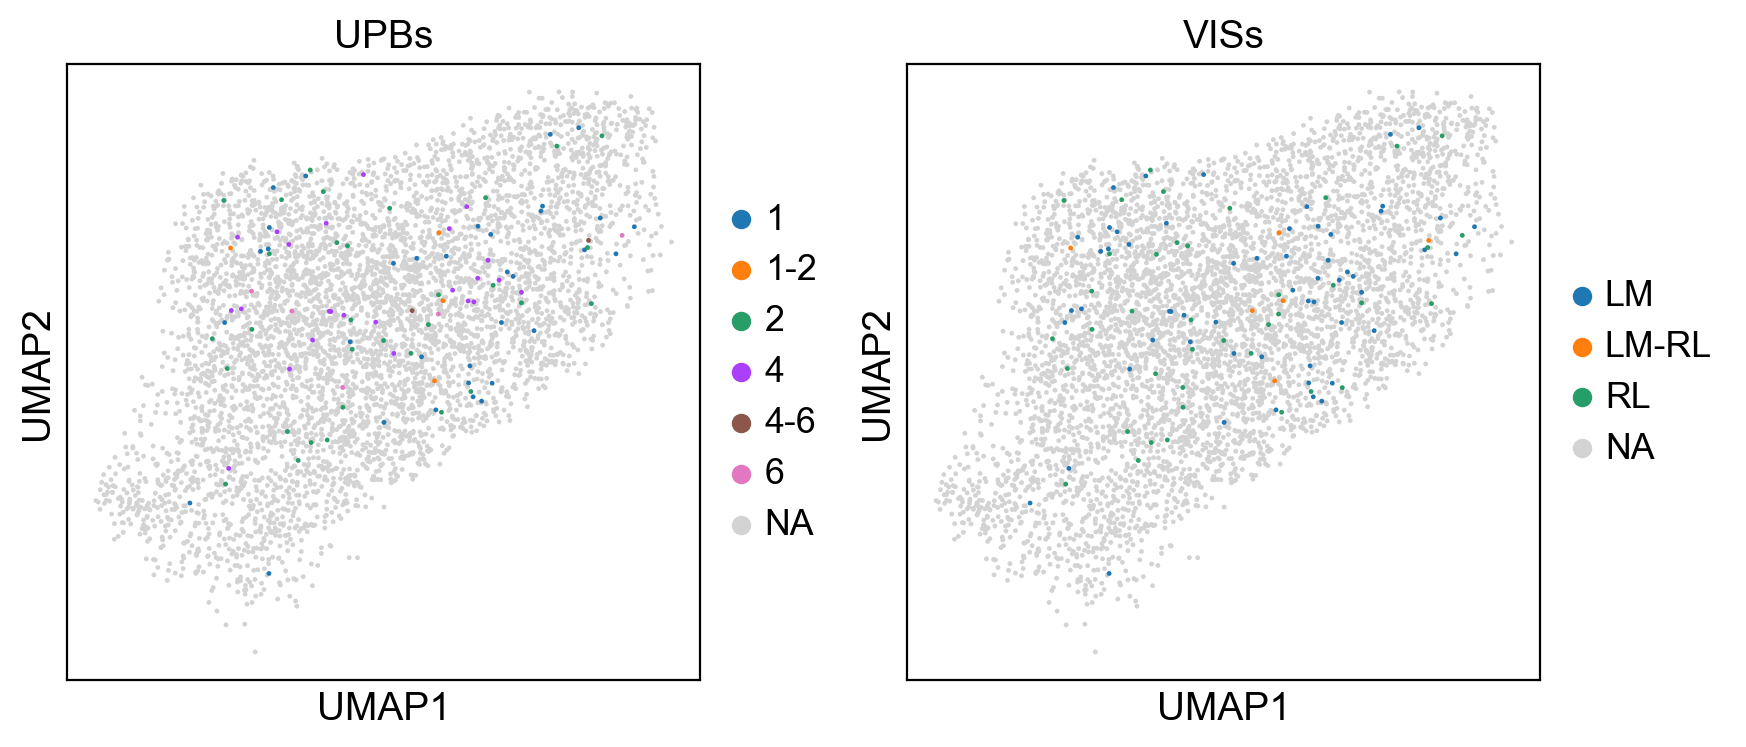

In [7]:
sc.pl.umap(adata, color=["UPBs", "VISs"], size=12)

In [8]:
import pandas as pd

adata.obs.reset_index(inplace=True, drop=True)

VISs = adata.obs["VISs"]
adata.obs["VISs"] = [None] * adata.shape[0]
for idx, vis in enumerate(VISs):
    if vis in ["LM", "RL", "LM-RL"]:
        adata.obs.loc[idx, "VISs"] = vis
    else:
        adata.obs.loc[idx, "VISs"] = "None"

In [9]:
adata_rand = adata.copy()
adata_de = adata[adata.obs["VISs"] != "None", :]
rand_idx = np.random.permutation(adata_rand.shape[0])
adata_rand.obs["VISs_rand"] = np.array(adata_rand.obs["VISs"])[rand_idx]
adata_rand = adata_rand[adata_rand.obs["VISs_rand"] != "None", :]

c:\Users\TLab\anaconda3\envs\scanpy\lib\site-packages\anndata\_core\anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [328]:
adata_de.X = adata_de.raw.X.toarray()

n_trees, n_top_genes, n_binary_genes, n_genes_eval = 1000, 35, 20, 6

results = ns.NSForest(
                    adata_de, 
                    cluster_header="VISs", 
                    n_trees=n_trees, 
                    n_top_genes=n_top_genes, 
                    n_binary_genes=n_binary_genes, 
                    n_genes_eval=n_genes_eval, 
                    output_folder=data_path + "NSForest/", 
                        )

Preparing data...
--- 0.0039899349212646484 seconds ---
Calculating medians...
--- 0.07280540466308594 seconds ---
Number of clusters to evaluate: 3
1 out of 3:
	LM
	['Spock3', 'Psmd7']
	0.7474226804123711
2 out of 3:
	LM-RL
	['Cript', 'Gpr150']
	0.8333333333333334
3 out of 3:
	RL
	['Cdyl2']
	0.6578947368421053
--- 6.697121620178223 seconds ---


C:\Ryan\GitHub\scanpy\scanpy\plotting\_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


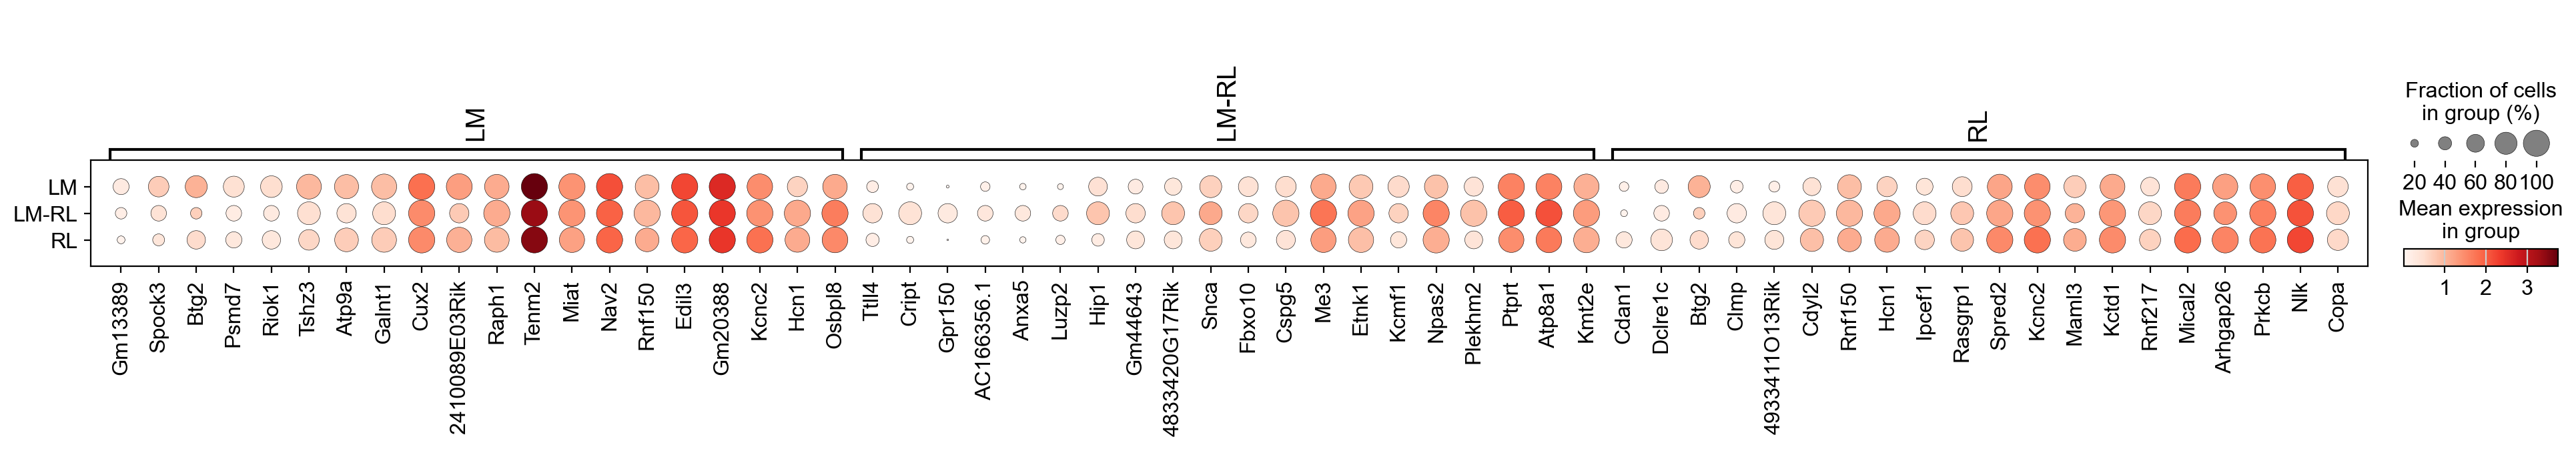

In [329]:
markers = dict(zip(results['clusterName'], results['binary_genes']))
sc.pl.dotplot(adata_de, markers, groupby="VISs", swap_axes=False)

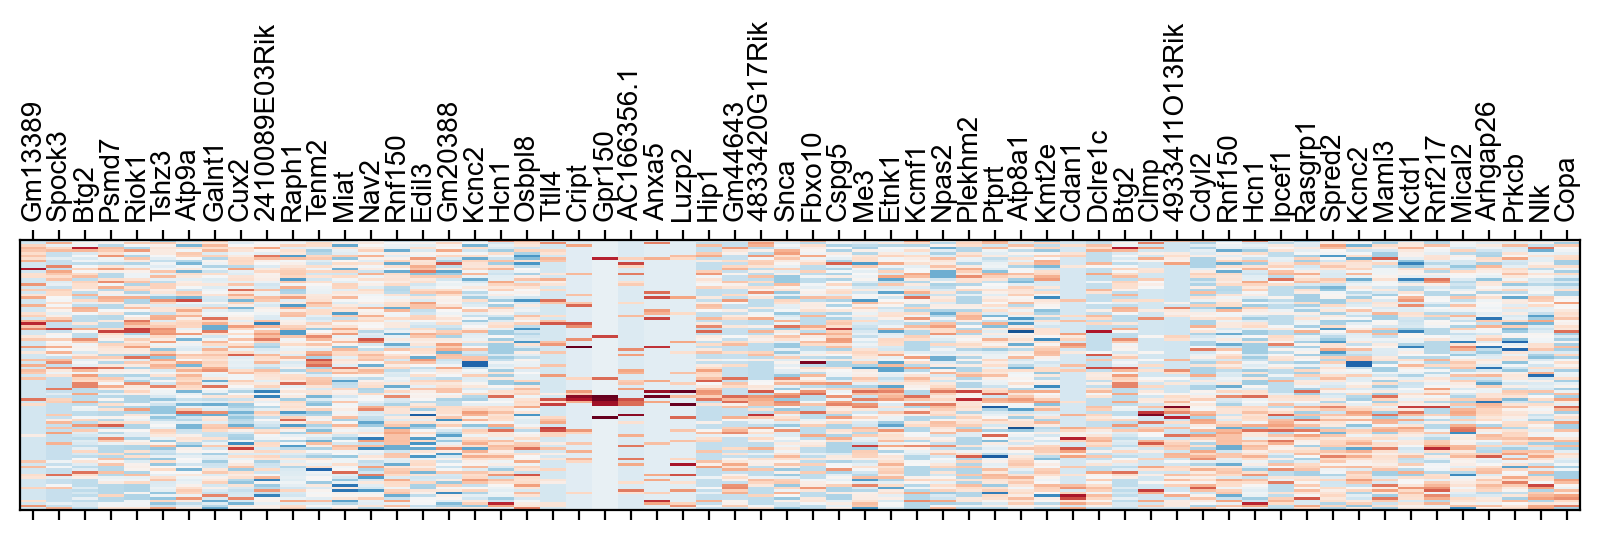

In [334]:
from scipy.stats import zscore
import pandas as pd
import matplotlib.pyplot as plt

all_markers = []
[all_markers.extend(markers) for markers in results["binary_genes"]]

df_X = pd.DataFrame(adata_de.raw[:, all_markers].X.toarray(), index=adata_de.obs_names, columns=all_markers) #cell-by-gene
clusters = adata_de.obs["VISs"]
df_X_clusters = pd.concat([df_X, clusters], axis=1)

matrix = np.array(df_X_clusters.sort_values(by=["VISs"], key=lambda col: col.str.lower()).drop(["VISs"], axis=1))

fig, ax = plt.subplots()
ax.matshow(zscore(matrix, axis=0), cmap="RdBu_r", aspect=0.1, vmin=-4, vmax=4) # 
ax.set_xticks(np.arange(0, len(all_markers), 1))
ax.set_xticklabels(all_markers, rotation=90, fontsize=10)
ax.set_yticks(())
ax.grid(False)
fig.set_size_inches(10, 8)
plt.show(block=False)

In [331]:
import sklearn.decomposition
pca = sklearn.decomposition.PCA(n_components=2)
X = zscore(matrix, axis=0)
X_r = pca.fit(X).transform(X)

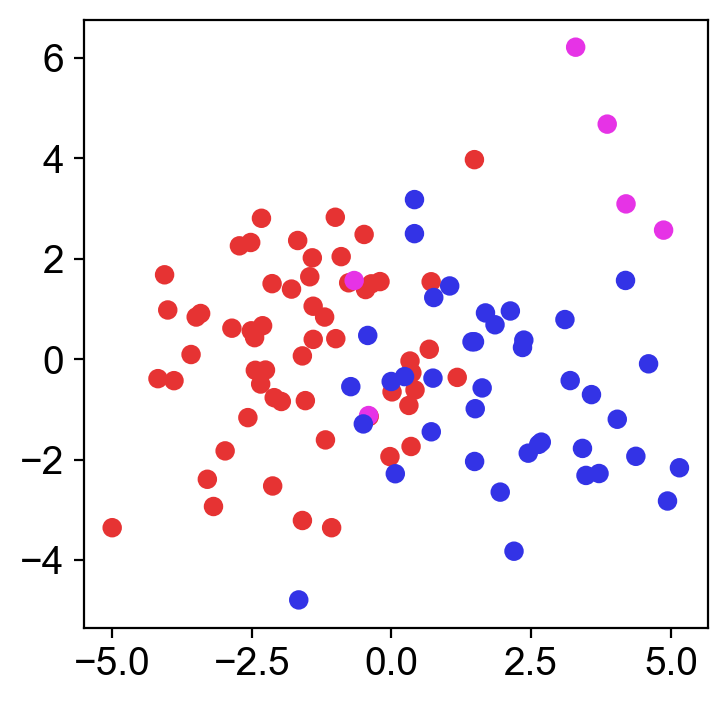

In [332]:
labels = df_X_clusters.sort_values(by=["VISs"])["VISs"]
colors = []
for cell in labels:
    if cell == "LM":
        colors.append((0.9, 0.2, 0.2))
    elif cell == "RL":
        colors.append((0.2, 0.2, 0.9))
    elif cell == "LM-RL":
        colors.append((0.9, 0.2, 0.9))

fig, ax = plt.subplots()
ax.scatter(X_r[:, 0], X_r[:, 1], c=colors)
ax.grid(False)
plt.show(block=False)

In [13]:
n_trees, n_top_genes, n_binary_genes, n_genes_eval = 1000, 35, 20, 6

results_rand = ns.NSForest(
                    adata_rand, 
                    cluster_header="VISs_rand", 
                    n_trees=n_trees, 
                    n_top_genes=n_top_genes, 
                    n_binary_genes=n_binary_genes, 
                    n_genes_eval=n_genes_eval, 
                        )

Preparing data...
--- 0.008975744247436523 seconds ---
Calculating medians...
--- 0.07081103324890137 seconds ---
Number of clusters to evaluate: 3
1 out of 3:
	LM
	['Kmt2e', 'Myt1l', 'Ogt']
	0.7766990291262137
2 out of 3:
	LM-RL
	Only 19 out of 35 top Random Forest features with median > 0 will be further evaluated.
	['Klhdc3', 'Mrpl21']
	0.8333333333333334
3 out of 3:
	RL
	Only 15 out of 35 top Random Forest features with median > 0 will be further evaluated.
	['9330159F19Rik']
	0.65
--- 6.790863513946533 seconds ---


c:\Users\TLab\anaconda3\envs\scanpy\lib\site-packages\anndata\_core\anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
c:\Users\TLab\anaconda3\envs\scanpy\lib\site-packages\anndata\_core\anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
C:\Ryan\GitHub\scanpy\scanpy\plotting\_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


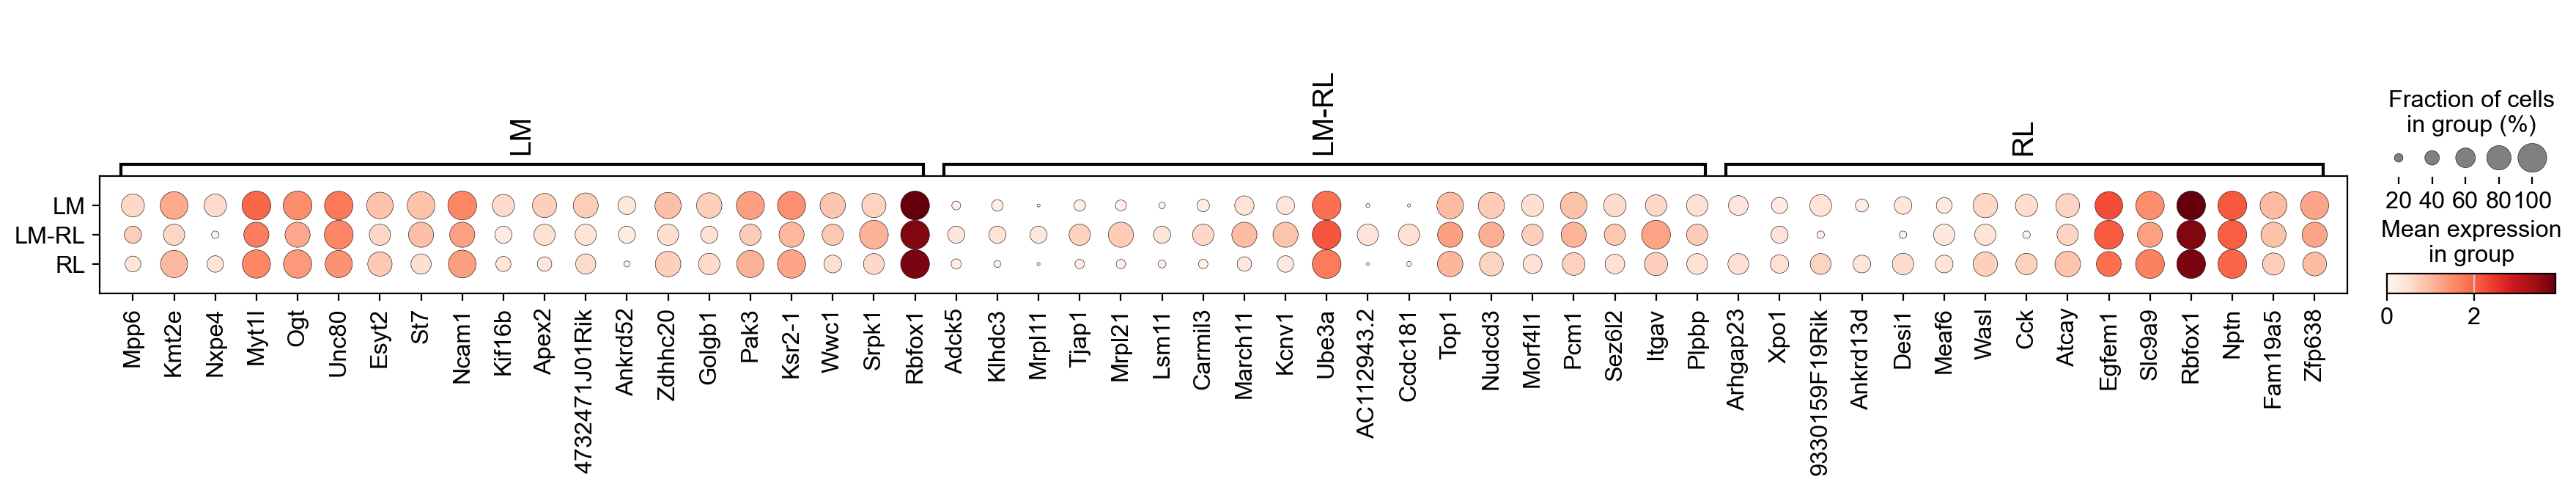

In [14]:
markers = dict(zip(results_rand['clusterName'], results_rand['binary_genes']))
sc.pl.dotplot(adata_rand, markers, groupby="VISs_rand", swap_axes=False)

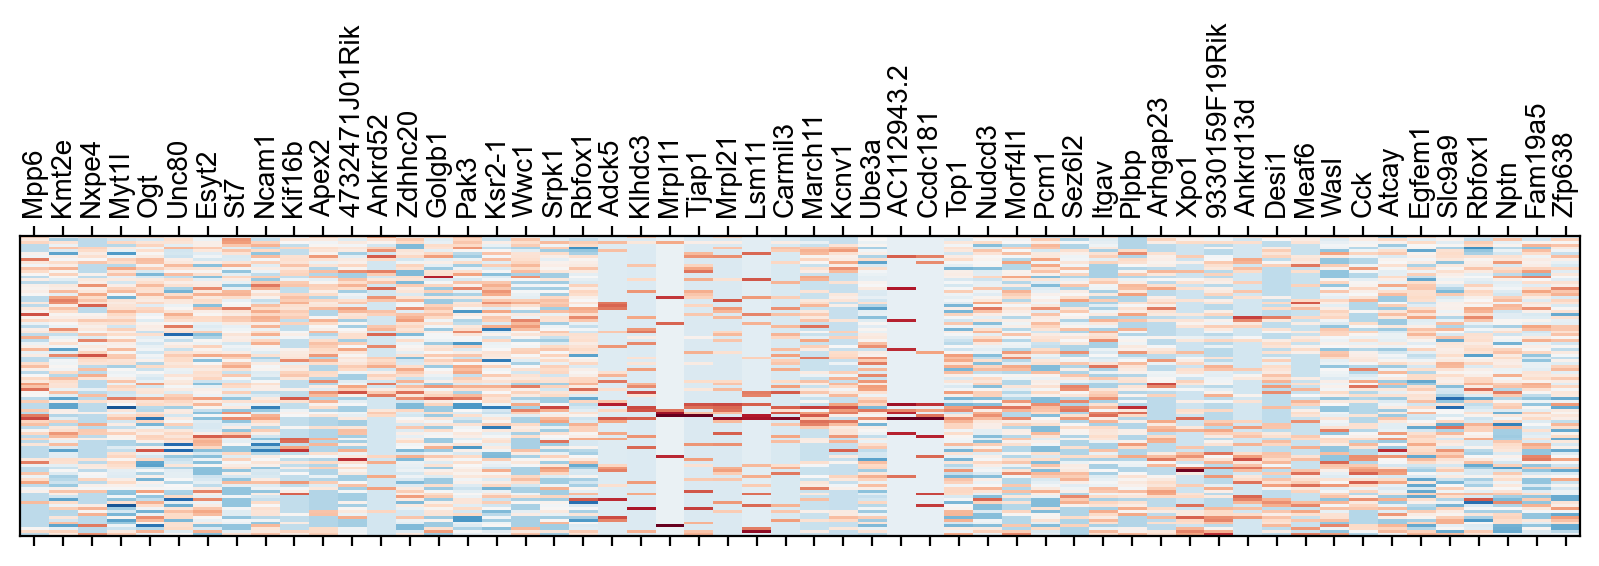

In [15]:
from scipy.stats import zscore
import pandas as pd
import matplotlib.pyplot as plt

all_markers = []
[all_markers.extend(markers) for markers in results_rand["binary_genes"]]

df_X = pd.DataFrame(adata_rand.raw[:, all_markers].X.toarray(), index=adata_rand.obs_names, columns=all_markers) #cell-by-gene
clusters = adata_rand.obs["VISs_rand"]
df_X_clusters = pd.concat([df_X, clusters], axis=1)

matrix = np.array(df_X_clusters.sort_values(by=["VISs_rand"], key=lambda col: col.str.lower()).drop(["VISs_rand"], axis=1))

fig, ax = plt.subplots()
ax.matshow(zscore(matrix, axis=0), cmap="RdBu_r", aspect=0.1, vmin=-4, vmax=4) # 
ax.set_xticks(np.arange(0, len(all_markers), 1))
ax.set_xticklabels(all_markers, rotation=90, fontsize=10)
ax.set_yticks(())
ax.grid(False)
fig.set_size_inches(10, 8)
plt.show(block=False)

In [16]:
import sklearn.decomposition
pca = sklearn.decomposition.PCA(n_components=2)
X = zscore(matrix, axis=0)
X_r = pca.fit(X).transform(X)

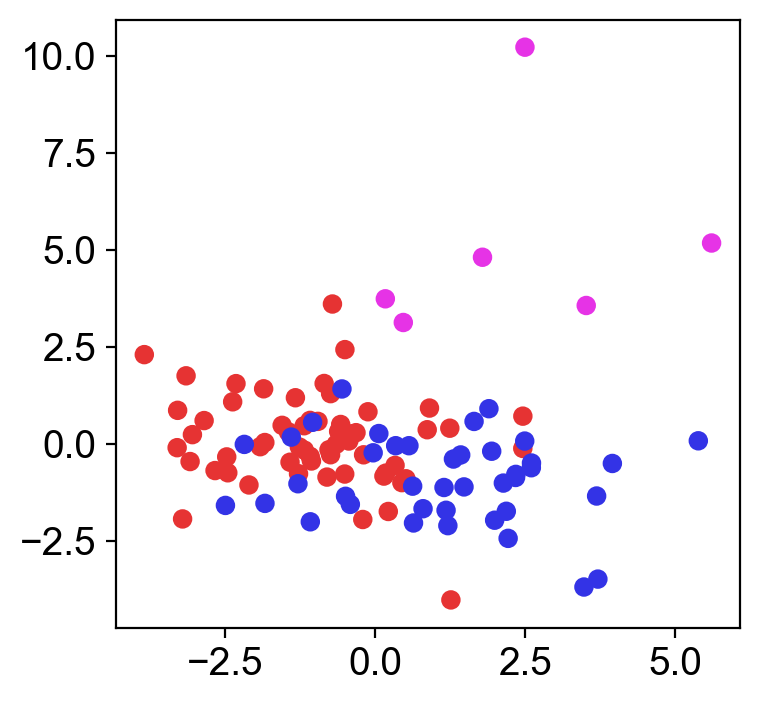

In [17]:
labels = df_X_clusters.sort_values(by=["VISs_rand"])["VISs_rand"]
colors = []
for cell in labels:
    if cell == "LM":
        colors.append((0.9, 0.2, 0.2))
    elif cell == "RL":
        colors.append((0.2, 0.2, 0.9))
    elif cell == "LM-RL":
        colors.append((0.9, 0.2, 0.9))

fig, ax = plt.subplots()
ax.scatter(X_r[:, 0], X_r[:, 1], c=colors)
ax.grid(False)
plt.show(block=False)